<a href="https://colab.research.google.com/github/ArditaHoti/FakeNewsDetection/blob/main/Final_of_FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=243791bc4666f6427eb6b8b26e9003f8636f1775f199c701fb30b0b01bfec082
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
  # Pyspark Core Libraries
from pyspark import SparkContext, SparkConf
# Pyspark SQL Libraries
from pyspark.sql import SQLContext, SparkSession
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.functions import isnan, when, count, col, udf, lower, regexp_replace, rand, round, lit, concat
# Pyspark MLlib - Feature Engineering
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, StringIndexer, HashingTF, IDF, Word2Vec
# Pyspark SQL Types
from pyspark.sql.types import IntegerType, StringType
# Pyspark MLlib - Model Building
from pyspark.ml import Pipeline
# Pyspark MLlib - Classifiers
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, DecisionTreeClassifier, GBTClassifier, LinearSVC
# Pyspark MLlib - Evaluation Metrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# Pyspark MLLib - Metrics
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
# Visualizations
import matplotlib.pyplot as plt
import numpy as np
import string
# Pyspark MLlib - Custom Transformers
from pyspark.ml import Transformer
# Pyspark MLlib - Parameters for Transformers
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
# Pyspark MLlib - Utility Functions
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

In [ ]:
#create a SparkConf with the following attributes:
#setAppName: Set application name
#setMaster: Set master URL to connect to
#spark driver memory is a flag that controls the amount of memory to allocate for a driver, which is 1GB by default. It is
#set to 15g to accomadate the text processing and training of models
conf = SparkConf().setAppName('Fake_news_detection').setMaster('local[4]').set('spark.driver.memory', '15g')

#create an entry point using SparkConf: conf
sc = SparkContext(conf=conf)
#SQLcontext is created using sc for realational functionality
sql_context = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Data Preprocessing

In [ ]:
#read the real news data
data = sql_context.read.csv('/content/drive/MyDrive/alb-fake-news-corpus.csv', header = True, inferSchema = True)


In [ ]:
#Check the length of dataframe
data.count()

3994

In [ ]:
#Drop out duplicates
data.dropDuplicates()

DataFrame[title: string, content: string, publication_datetime: string, facebook_url: string, web_page_url: string, number_of_tokens: string, number_of_words_without_punctuation: string, number_of_words_in_upper_case: string, average_word_length: string, number_of_characters: string, number_of_letters_in_upper_case: string, number_of_verbs: string, number_of_subjuntive: string, number_of_imperative_verbs: string, number_of_nouns: string, number_of_adjectives: string, number_of_adverbs: string, number_of_pronouns: string, number_of_modal_verbs: string, fake_news: string]

In [ ]:
#Check the length of dataframe to check if there were duplicates after deleting them
data.count()

3994

In [ ]:
data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------------------------+-----------------------------+-------------------+--------------------+-------------------------------+---------------+--------------------+--------------------------+---------------+--------------------+-----------------+------------------+---------------------+---------+
|               title|             content|publication_datetime|        facebook_url|        web_page_url|number_of_tokens|number_of_words_without_punctuation|number_of_words_in_upper_case|average_word_length|number_of_characters|number_of_letters_in_upper_case|number_of_verbs|number_of_subjuntive|number_of_imperative_verbs|number_of_nouns|number_of_adjectives|number_of_adverbs|number_of_pronouns|number_of_modal_verbs|fake_news|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------

In [ ]:
# Collect the count of missing values in each column
missing_counts = [data.where(col(column).isNull()).count() for column in data.columns]
print(missing_counts)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
data.printSchema()

root
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)
 |-- publication_datetime: string (nullable = true)
 |-- facebook_url: string (nullable = true)
 |-- web_page_url: string (nullable = true)
 |-- number_of_tokens: string (nullable = true)
 |-- number_of_words_without_punctuation: string (nullable = true)
 |-- number_of_words_in_upper_case: string (nullable = true)
 |-- average_word_length: string (nullable = true)
 |-- number_of_characters: string (nullable = true)
 |-- number_of_letters_in_upper_case: string (nullable = true)
 |-- number_of_verbs: string (nullable = true)
 |-- number_of_subjuntive: string (nullable = true)
 |-- number_of_imperative_verbs: string (nullable = true)
 |-- number_of_nouns: string (nullable = true)
 |-- number_of_adjectives: string (nullable = true)
 |-- number_of_adverbs: string (nullable = true)
 |-- number_of_pronouns: string (nullable = true)
 |-- number_of_modal_verbs: string (nullable = true)
 |-- fake_news: string (nulla

Show all the values in fake_news column, which will be used as target column

In [ ]:
data.groupBy('fake_news').count().show(80)

+--------------------+-----+
|           fake_news|count|
+--------------------+-----+
|        pos federata|    1|
|  Aragon dhe Navarra|    1|
|         Arben Gashi|    2|
|                 232|    1|
| përkatësisht pol...|    1|
|                   3|    2|
|                  34|    1|
|            kumbullë|    1|
| Vjosa Osmanit dh...|    1|
|                 670|    1|
|                1143|    1|
|                   0|   10|
|               False| 1934|
| bëhu i sinqertë ...|    1|
|                  17|    1|
| shkruante Macgre...|    1|
| ne kemi punuar 1...|    1|
| kanë pasur pakën...|    1|
|                   6|    1|
| gati dyfishë më ...|    1|
| por kësaj here s...|    1|
|https://www.botas...|    1|
| për mbrojtjen e ...|    1|
|                  40|    1|
| anëtarja nga Par...|    3|
|                  25|    1|
|http://www.botaso...|    1|
| vendi më i madh ...|    1|
|                 612|    1|
|                  58|    1|
| ku pas dy shekuj...|    1|
| si vlera të 

Since we are focused in a two labeled classification, whether the article is true or false, we will replace any other values than True to False

In [ ]:
# Replace values other than "False" and "True" with "False"
df_new = data.withColumn("fake_news", when((col("fake_news") == "True") | (col("fake_news") == "False"), col("fake_news")).otherwise("False"))

In [ ]:
#drop rows where fake_news is different from True or False
#df_new = data.filter((F.col('fake_news') == 'True') | (F.col('fake_news') == 'False'))

#view new DataFrame
df_new.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------------------------+-----------------------------+-------------------+--------------------+-------------------------------+---------------+--------------------+--------------------------+---------------+--------------------+-----------------+------------------+---------------------+---------+
|               title|             content|publication_datetime|        facebook_url|        web_page_url|number_of_tokens|number_of_words_without_punctuation|number_of_words_in_upper_case|average_word_length|number_of_characters|number_of_letters_in_upper_case|number_of_verbs|number_of_subjuntive|number_of_imperative_verbs|number_of_nouns|number_of_adjectives|number_of_adverbs|number_of_pronouns|number_of_modal_verbs|fake_news|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------

In [ ]:
df_new.count()

3994

In [ ]:
df_new.groupBy('fake_news').count().show()

+---------+-----+
|fake_news|count|
+---------+-----+
|    False| 1998|
|     True| 1996|
+---------+-----+



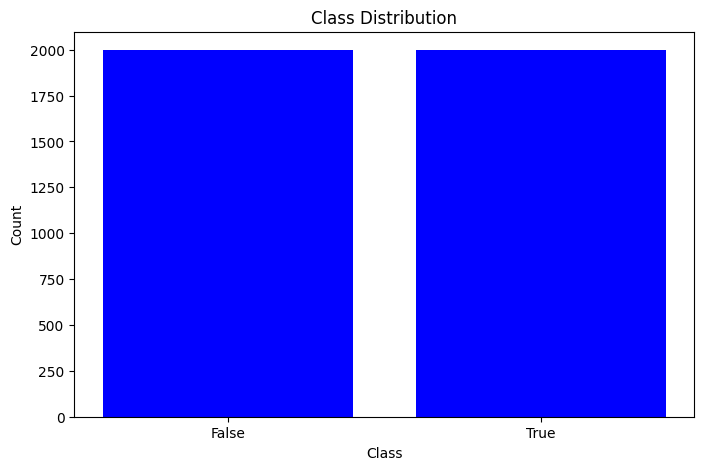

In [ ]:
# Count the number of occurrences for each unique value in the 'fake_news' column
class_counts = df_new.groupBy('fake_news').count().collect()

# Extract class labels and counts for plotting
labels = [str(row['fake_news']) for row in class_counts]
counts = [row['count'] for row in class_counts]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='blue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## **Feature Engineering**

In [ ]:
# Concatenate 'title' and 'content' columns into a new column 'news_article'
df_new = df_new.withColumn('news_article', concat(col('title'), lit(' '), col('content')))



In [ ]:
df_new.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------------------------+-----------------------------+-------------------+--------------------+-------------------------------+---------------+--------------------+--------------------------+---------------+--------------------+-----------------+------------------+---------------------+---------+--------------------+
|               title|             content|publication_datetime|        facebook_url|        web_page_url|number_of_tokens|number_of_words_without_punctuation|number_of_words_in_upper_case|average_word_length|number_of_characters|number_of_letters_in_upper_case|number_of_verbs|number_of_subjuntive|number_of_imperative_verbs|number_of_nouns|number_of_adjectives|number_of_adverbs|number_of_pronouns|number_of_modal_verbs|fake_news|        news_article|
+--------------------+--------------------+--------------------+--------------------+-------

 ## **Data Cleaning**


In [ ]:
#remove all columns except fake_news and news_article
columns = ["title","content", "publication_datetime", "facebook_url","number_of_tokens","number_of_words_without_punctuation",
           "number_of_words_in_upper_case","average_word_length","number_of_characters","number_of_letters_in_upper_case",
           "number_of_verbs","number_of_subjuntive","number_of_imperative_verbs","number_of_nouns","number_of_adjectives","number_of_modal_verbs","number_of_adverbs",
           "number_of_pronouns","web_page_url"]
df_new = df_new.drop(*columns)

In [ ]:
df_new.show(10)

+---------+--------------------+
|fake_news|        news_article|
+---------+--------------------+
|    False|Studimi gjerman: ...|
|    False|Labinot Tahiri: G...|
|    False|Parashikon Albule...|
|    False|Covid-19 rriti la...|
|    False|Kryeministri Hoti...|
|    False|Hoti: Do t’i dyfi...|
|    False|Prokuroria: I dys...|
|    False|Prokuroria: I dys...|
|    False|Alarmante - Rreth...|
|    False|Numri i të infekt...|
+---------+--------------------+
only showing top 10 rows



In [ ]:
#print the schema of the data
df_new.printSchema()

root
 |-- fake_news: string (nullable = true)
 |-- news_article: string (nullable = true)



 ,**Text Preprocessing using NLP**

The text preprocessing involves the following steps:

1. Tokenize the text into words using RegexTokenizer which is more advanced tokenization based on regular expression matching
2. Removal of Stopwords using StopWordsRemover. Albanian stopwords are used to remove unwanted words from the data.
3. Converting text to numerical. We moved out from Word2Vec to Hash TFIDF, because negative values created was not accepptable in our NAive Bayes Model.

4. Convert target categorical values into intergers using StringIndexer.  StringIndexer encodes a string column of labels to a column of label indices.



In [ ]:
# Albanian stop words list

""" Resource of Albainan stop words https://betimdrenica.com/2012/05/21/albanian-stop-words.html"""

add_stopwords = ["a","apo","asnjë","asnje","ata","ato","ca","deri","dhe","do","e","i",
"jam","janë","jane","jemi","jeni","ju","juaj","kam","kaq","ke","kemi","kete","këtë",
"më" ,"me","mu","në" ,"ne","nëse","nese""një","nje","nuk","pa","pas","pasi","për","per",
"prej","që","qe","sa","së","se","seç" ,"sec""si","saj","të","te","ti","tek","tij","tonë", "tone",
"tuaj","ty","tyre","unë" ,"une","veç", "vec"]

# Define a custom transformer for removing punctuation from a text column
class PunctuationRemover(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    """
    A PySpark transformer for removing punctuation from a text column.
    """

    def __init__(self, inputCol=None, outputCol=None):
        super(PunctuationRemover, self).__init__()
        self._setDefault(inputCol=inputCol, outputCol=outputCol)

    def _transform(self, df):
        """
        Transforms the input DataFrame by removing punctuation from the specified text column.

        Parameters:
        - df: The input DataFrame.

        Returns:
        - Transformed DataFrame with punctuation removed.
        """
        input_col = self.getInputCol()  # Get input column
        output_col = self.getOutputCol()  # Get output column

        # Create a User-Defined Function (UDF) to remove punctuation
        remove_punct_udf = F.udf(lambda text: text.translate(str.maketrans('', '', string.punctuation)) if text else text, StringType())

        # Apply the UDF and add a new column with the result
        return df.withColumn(output_col, remove_punct_udf(F.col(input_col)))
# Punctuation removal
punct_remover = PunctuationRemover(inputCol="news_article", outputCol="text_no_punct")

# Tokenization
tokenizer = RegexTokenizer(inputCol="text_no_punct", outputCol="words", pattern="\\W")

# Stopwords removal
remover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# TF-IDF (Term Frequency-Inverse Document Frequency)
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Label Indexer
label_stringIdx = StringIndexer(inputCol="fake_news", outputCol="label")

# Pipeline for text preprocessing
pipeline = Pipeline(stages=[punct_remover, tokenizer, remover, hashingTF, idf, label_stringIdx])

# Fit the pipeline on the dataset
pipelineFit = pipeline.fit(df_new)
dataset = pipelineFit.transform(df_new)



In [ ]:
# Show 10 random rows from the DataFrame
dataset.orderBy(rand()).show(10)


+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|fake_news|        news_article|       text_no_punct|               words|            filtered|         rawFeatures|            features|label|
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|     True|Ndodhi më e keqja...|Ndodhi më e keqja...|[ndodhi, m, e, ke...|[ndodhi, m, keqja...|(262144,[4748,740...|(262144,[4748,740...|  1.0|
|    False|​Kush hedh doreza...|​Kush hedh doreza...|[kush, hedh, dore...|[kush, hedh, dore...|(262144,[1303,591...|(262144,[1303,591...|  0.0|
|    False|Haradinaj kundër ...|Haradinaj kundër ...|[haradinaj, kund,...|[haradinaj, kund,...|(262144,[278,4412...|(262144,[278,4412...|  0.0|
|     True|Në momentin kur u...|Në momentin kur u...|[n, momentin, kur...|[n, momentin, kur...|(262144,[1303,376...|(262144,[1303,376...

The data is converted to numerical format and below shows the schema of the preprocessed data.

In [ ]:
#check the schema for preprocessed data
dataset.printSchema()

root
 |-- fake_news: string (nullable = true)
 |-- news_article: string (nullable = true)
 |-- text_no_punct: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



**5. Function for Evaluation Metrics**

This project is implmented using five machine learning algorithms. The performance of the models are evaluated confusion matrix, F1 score and Area under the curve. The model with less False positives and false negatives, high F1 score and AUC will be considered as a better model for fake news detection. Matplotlib and Numpy is used to plot the confusion matrix.


In [ ]:
#function to calculate the evaluation metrics
def evalualte_metrics(predictions):
    '''Accuracy'''
    #label = predictions.select(['prediction', 'label'])
    evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
    accuracy = evaluator.evaluate(predictions)*100

    #select prediction and label columns to calculate metric values
    results = predictions.select(['prediction', 'label'])
    #convert the results to rdd to get predictions and labels
    predictionAndLabels = results.rdd
    '''Area under the curve'''
    binary_evaluator = BinaryClassificationMetrics(predictionAndLabels)
    auc = binary_evaluator.areaUnderROC
    '''Classification report'''
    #create a multiclassmetrics instance
    metrics = MulticlassMetrics(predictionAndLabels)
    #compute Recall with respect to Real and fake news data
    real_recall = metrics.recall(1.0)
    fake_recall = metrics.recall(0.0)
    #compute Precision with respect to Real and fake news data
    real_precision = metrics.precision(1.0)
    fake_precision = metrics.precision(0.0)
    #compute F1 Score with respect to Real and fake news data
    real_f1 = metrics.fMeasure(1.0)
    fake_f1 = metrics.fMeasure(0.0)
    #create a classificaiton report for the model
    real = Row(News = 'Real', recall = real_recall, precision = real_precision, f1_score = real_f1)
    fake = Row(News = 'Fake', recall = fake_recall, precision = fake_precision, f1_score = fake_f1)
    classification_report = [real, fake]
    classification_report_df = sql_context.createDataFrame(classification_report)
    '''Confusion matrix'''
    conf_matrix = metrics.confusionMatrix().toArray()
    # List of models
    return accuracy, auc, classification_report_df, conf_matrix
    # List of models
    model_names = []
    accuracies = []
    aucs = []

In [ ]:
#function for confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

**6. Modelling**

This section implements different algorithms to predict the fake news. Initially the data is split into train and test in the ratio 70:30 using randomSplit function.


In [ ]:
#split the data
train, test = dataset.randomSplit([0.7, 0.3])


In [ ]:
#check the train and test data count
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 2792
Test Dataset Count: 1202


## Logistic Regression Model

In [ ]:
lr = LogisticRegression(labelCol="label", featuresCol="features")

In [ ]:
#Fit the model to the data
lrModel = lr.fit(train)
lr_predictions = lrModel.transform(test)
print(lrModel)


LogisticRegressionModel: uid=LogisticRegression_c2eafc450654, numClasses=2, numFeatures=262144


In [ ]:
#calculate the evaluation metrics of LogisticRegression model
lr_accuracy, lr_auc, lr_classification_report_df, lr_conf_matrix = evalualte_metrics(lr_predictions)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# List of models
model_names = []
accuracies = []
aucs = []
#print the auuracy and area under the curve
print("Logistic Regression accuracy is: {:0.2f}".format(lr_accuracy))
print("Logistic Regression AUC is: {:0.2f}".format(lr_auc))
# Append results for the Random Forest model
model_names.append("Logistic Regression")
accuracies.append(lr_accuracy)
aucs.append(lr_auc)

Logistic Regression accuracy is: 87.10
Logistic Regression AUC is: 0.87


In [ ]:
#display the classification report
lr_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.9036918138041734|0.8556231003039514| 0.879000780640125|
|Fake|0.8359240069084629|0.8897058823529411|0.8619768477292965|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(lr_conf_matrix)

Confusion Matrix
[[484.  95.]
 [ 60. 563.]]


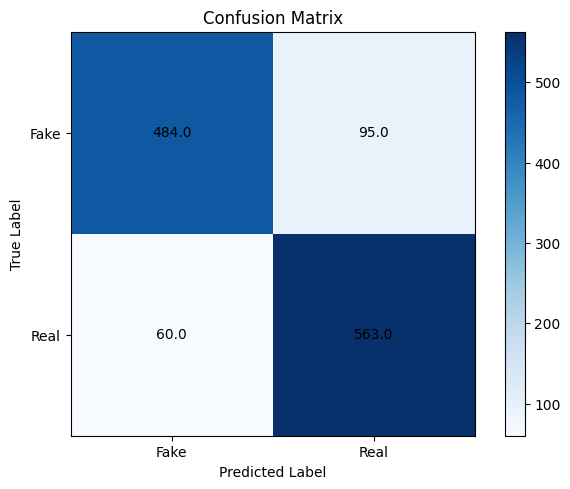

In [ ]:
#plot confusion matrix
plot_confusion_matrix(lr_conf_matrix,["Fake","Real"])

## Random Forest Model

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [ ]:
#Fit the model to the data
rfModel = rf.fit(train)
rf_predictions = rfModel.transform(test)
print(rfModel)

RandomForestClassificationModel: uid=RandomForestClassifier_5421b0015852, numTrees=20, numClasses=2, numFeatures=262144


In [ ]:
#calculate the evaluation metrics of LogisticRegression model
rf_accuracy, rf_auc, rf_classification_report_df, rf_conf_matrix = evalualte_metrics(rf_predictions)

In [ ]:
#print the auuracy and area under the curve
print("Random Forest accuracy is: {:0.2f}".format(rf_accuracy))
print("Random Forest AUC is: {:0.2f}".format(rf_auc))

Random Forest accuracy is: 77.54
Random Forest AUC is: 0.77


In [ ]:
#display the classification report
rf_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.8186195826645265|0.7646176911544228|0.7906976744186047|
|Fake|0.7288428324697754| 0.788785046728972|0.7576301615798923|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(rf_conf_matrix)
# Append results for the Random Forest model
model_names.append("Random Forest")
accuracies.append(rf_accuracy)
aucs.append(rf_auc)

Confusion Matrix
[[422. 157.]
 [113. 510.]]


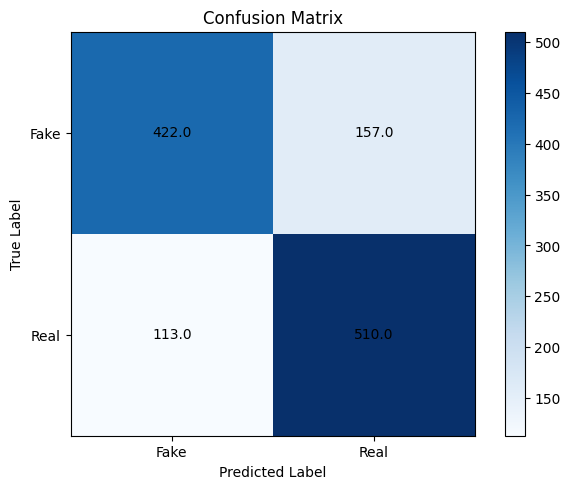

In [ ]:
#plot confusion matrix
plot_confusion_matrix(rf_conf_matrix,["Fake","Real"])

## **Decision Tree Model**


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
#define decision tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol = "features")

#train the model and predict on test data
dtModel = dt.fit(train)
dt_predictions = dtModel.transform(test)

In [ ]:
#calculate the evaluation metrics of decision tree model
dt_accuracy, dt_auc, dt_classification_report_df, dt_conf_matrix = evalualte_metrics(dt_predictions)

In [ ]:
#print the auuracy and area under the curve
print("Decision Tree accuracy is: {:0.2f}".format(dt_accuracy))
print("Decision Tree AUC is: {:0.2f}".format(dt_auc))
# Append results for the Random Forest model
model_names.append("Decision Tree")
accuracies.append(dt_accuracy)
aucs.append(dt_auc)

Decision Tree accuracy is: 77.70
Decision Tree AUC is: 0.78


In [ ]:
#display the classification report
dt_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.5698234349919743|               1.0|0.7259713701431492|
|Fake|               1.0|0.6835891381345927|0.8120617110799438|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(dt_conf_matrix)

Confusion Matrix
[[579.   0.]
 [268. 355.]]


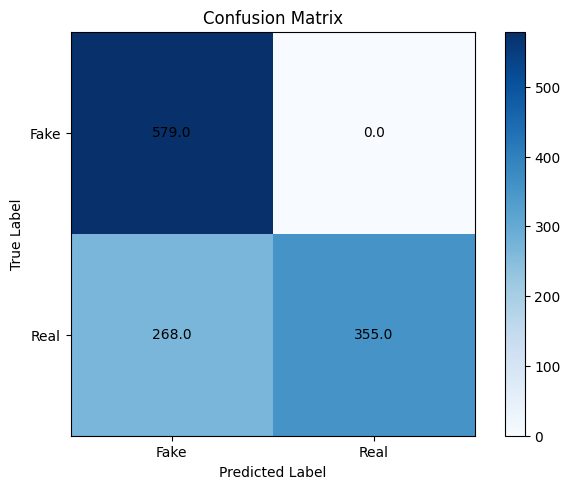

In [ ]:
#plot confusion matrix
plot_confusion_matrix(dt_conf_matrix,["Fake","Real"])

## Naive Bayes

In [ ]:
nb = NaiveBayes(labelCol="label", featuresCol="features")

In [ ]:
#train the model and predict on test data
nbModel = nb.fit(train)
nb_predictions = nbModel.transform(test)

In [ ]:
#calculate the evaluation metrics of decision tree model
nb_accuracy, nb_auc, nb_classification_report_df, nb_conf_matrix = evalualte_metrics(nb_predictions)

In [ ]:
#print the auuracy and area under the curve
print("Naive Bayes accuracy is: {:0.2f}".format(nb_accuracy))
print("Naive Bayes AUC is: {:0.2f}".format(nb_auc))
# Append results for the Random Forest model
model_names.append("Naive Bayes")
accuracies.append(nb_accuracy)
aucs.append(nb_auc)

Naive Bayes accuracy is: 84.28
Naive Bayes AUC is: 0.85


In [ ]:
#display the classification report
nb_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.7720706260032103|0.9109848484848485|0.8357949609035622|
|Fake| 0.918825561312608|0.7893175074183977|0.8491620111731845|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(nb_conf_matrix)

Confusion Matrix
[[532.  47.]
 [142. 481.]]


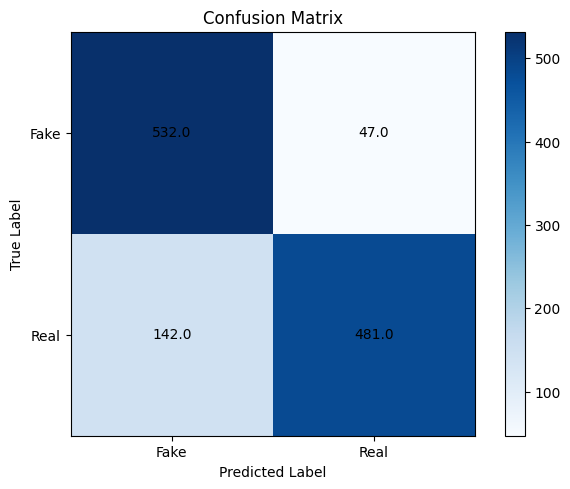

In [ ]:
#plot confusion matrix
plot_confusion_matrix(nb_conf_matrix,["Fake","Real"])

#Gradient-Boosted Tree

In [ ]:
gb = GBTClassifier(labelCol="label", featuresCol="features")
#train the model and predict on test data
gbModel = gb.fit(train)
gb_predictions = gbModel.transform(test)

#calculate the evaluation metrics of decision tree model
gb_accuracy, gb_auc, gb_classification_report_df, gb_conf_matrix = evalualte_metrics(gb_predictions)


In [ ]:
#print the auuracy and area under the curve
print("Gardient Booster accuracy is: {:0.2f}".format(gb_accuracy))
print("Gardient Booster AUC is: {:0.2f}".format(gb_auc))
# Append results for the Gardient Boost Tree model
model_names.append("Gardient Booster")
accuracies.append(gb_accuracy)
aucs.append(gb_auc)

Gardient Booster accuracy is: 85.77
Gardient Booster AUC is: 0.86


In [ ]:
#display the classification report
gb_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real| 0.797752808988764|0.9169741697416974|0.8532188841201717|
|Fake|0.9222797927461139|0.8090909090909091|0.8619854721549637|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(gb_conf_matrix)

Confusion Matrix
[[534.  45.]
 [126. 497.]]


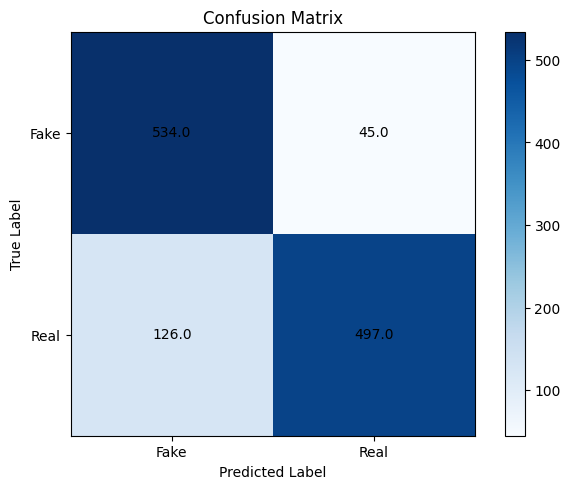

In [ ]:
#plot confusion matrix
plot_confusion_matrix(gb_conf_matrix,["Fake","Real"])

### **Linear SVM - linear support vector machine classifier**

In [ ]:
# Train the model
classifier = LinearSVC(maxIter=1000)
lsvc_model = classifier.fit(train)

# Make predictions
lsvc_predictions = lsvc_model.transform(test)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#calculate the evaluation metrics of decision tree model
lsvc_accuracy, lsvc_auc, lsvc_classification_report_df, lsvc_conf_matrix = evalualte_metrics(lsvc_predictions)
#print the auuracy and area under the curve
print("Linear SVC accuracy is: {:0.2f}".format(lsvc_accuracy))
print("Linear SVC AUC is: {:0.2f}".format(lsvc_auc))
# Append results
model_names.append("Linear SVC")
accuracies.append(lsvc_accuracy)
aucs.append(lsvc_auc)

Linear SVC accuracy is: 88.52
Linear SVC AUC is: 0.89


In [ ]:
#display the classification report
lsvc_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.8747993579454254|0.9008264462809917|0.8876221498371335|
|Fake|0.8963730569948186|0.8693467336683417|0.8826530612244897|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(lsvc_conf_matrix)

Confusion Matrix
[[519.  60.]
 [ 78. 545.]]


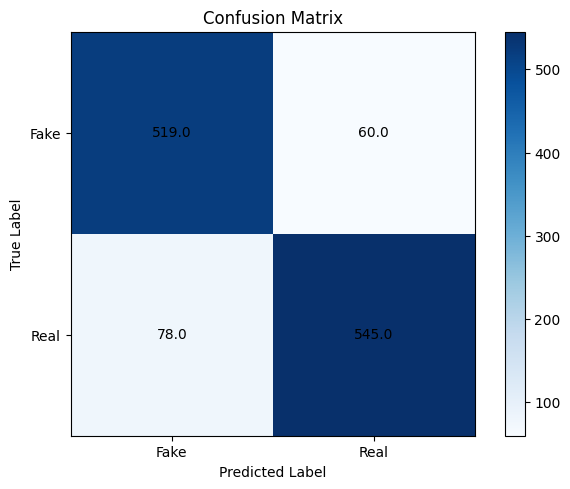

In [ ]:
#plot confusion matrix
plot_confusion_matrix(lsvc_conf_matrix,["Fake","Real"])

In [ ]:
import pandas as pd

# create a pandas DataFrame to show the results of models
df_models = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "AUC": aucs
})

# Print the DataFrame
print(df_models)

                 Model   Accuracy       AUC
0  Logistic Regression  87.104825  0.869808
1        Random Forest  77.537438  0.773731
2        Decision Tree  77.703827  0.784912
3          Naive Bayes  84.276206  0.845448
4     Gardient Booster  85.773710  0.860016
5           Linear SVC  88.519135  0.885586


In [ ]:
#! pip install streamlit -q
!pip install -q streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Save the fitted pipeline using PySpark's built-in methods
pipelineFit.write().overwrite().save("fake_news_pipeline")

# Save the Linear SVC model using PySpark's built-in methods
lsvc_model.write().overwrite().save("lsvc_model")


In [ ]:
%%writefile app.py
import streamlit as st
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LinearSVCModel
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
import pyspark.sql.functions as F
from pyspark.sql.types import StringType
import string

# Initialize Spark session
spark = SparkSession.builder.appName("FakeNewsDetectionApp").getOrCreate()

# Define a custom transformer for removing punctuation from a text column
class PunctuationRemover(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCol=None, outputCol=None):
        super(PunctuationRemover, self).__init__()
        self._setDefault(inputCol=inputCol, outputCol=outputCol)
        self.setParams(inputCol=inputCol, outputCol=outputCol)

    def setParams(self, inputCol=None, outputCol=None):
        if inputCol:
            self.setInputCol(inputCol)
        if outputCol:
            self.setOutputCol(outputCol)
        return self

    def _transform(self, df):
        input_col = self.getInputCol()
        output_col = self.getOutputCol()
        if not input_col or not output_col:
            raise ValueError("Input column and output column must be set")
        remove_punct_udf = F.udf(lambda text: text.translate(str.maketrans('', '', string.punctuation)), StringType())
        return df.withColumn(output_col, remove_punct_udf(F.col(input_col)))

# Load the saved pipeline model
pipeline_model_path = "fake_news_pipeline"
lsvc_model_path = "lsvc_model"

pipeline_model = None
lsvc_model = None

pipeline_model = PipelineModel.load(pipeline_model_path)
lsvc_model = LinearSVCModel.load(lsvc_model_path)

# Function to preprocess the input data
def preprocess_data(input_text):
    try:
        # Create a DataFrame from the input text
        df_input = spark.createDataFrame([(input_text,)], ["news_article"])

        # Check if pipeline model has stages
        if not pipeline_model.stages:
            st.error("Pipeline model has no stages.")
            return None

        # Apply the pipeline stages manually excluding label transformations
        for stage in pipeline_model.stages:
            # Ensure the stage is a valid transformer
            if isinstance(stage, Transformer):
                df_input = stage.transform(df_input)
            else:
                st.error(f"Stage {stage.__class__.__name__} is not a valid Transformer")

        return df_input
    except Exception as e:
        st.error(f"Error in preprocessing data: {e}")
        return None

# Streamlit app
def main():

# Inject custom CSS to set the video as the background
    st.markdown(
        """
        <style>
        .stApp {
            background: url("https://cdn.pixabay.com/video/2024/06/21/217643_small.mp4") no-repeat center center fixed;
            background-size: cover;
            color: white;
        }
        .stButton>button {
        background-color: #4CAF50; /* Change the background color of the button */
        color: white; /* Change the text color to white */
        border-radius: 12px; /* Optional: Make the button rounded */
        font-size: 16px; /* Optional: Increase the font size */
        padding: 10px 24px; /* Optional: Add some padding */
        }
        .stMarkdown h1 {
        color: white; /* Change the title color here */
        }
        video#bgvid {
            position: fixed;
            right: 0;
            bottom: 0;
            min-width: 100%;
            min-height: 100%;
            z-index: -1;
        }
        </style>

        <video autoplay muted loop id="bgvid">
            <source src="https://cdn.pixabay.com/video/2024/06/21/217643_small.mp4" type="video/mp4">
        </video>
        """,
        unsafe_allow_html=True
    )
    st.title("Fake News Detection")

    # Input text box
    input_text = st.text_area("Enter the news text:")

    if st.button("Predict"):
        if input_text.strip() != "":
            # Preprocess the input text
            processed_data = preprocess_data(input_text)

            if processed_data is not None:
                try:
                    # Make predictions
                    predictions = lsvc_model.transform(processed_data)

                    # Show the prediction results
                    prediction_result = predictions.select("prediction").collect()[0]
                    st.write(f"Prediction: {'Fake' if prediction_result['prediction'] == 0.0 else 'Real'}")
                except Exception as e:
                    st.error(f"Error in making predictions: {e}")
            else:
                st.write("An error occurred during preprocessing.")
        else:
            st.write("Please enter some text to predict.")

if __name__ == "__main__":
    main()


Writing app.py


In [ ]:
!npm install localtunnel


added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues, run:
  npm audit fix

Run `npm audit` for details.


In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.185.142.112


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.142.112:8501

your url is: https://tender-sites-hear.loca.lt
